In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yuktapadgaonkar","key":"731aa27faf4579344e1c5177e8f6df15"}'}

In [5]:
from google.colab import drive
try:
    drive.mount('/content/drive', )
    OUT_DIR = "/content/drive/MyDrive/CMPE-257_Yolov8"
    DRIVE_OK = True
    print("Drive mounted, results will be saved to:", OUT_DIR)
except Exception as e:
    print("⚠️ Drive mount failed:", e)
    OUT_DIR = "/content/drive/MyDrive/CMPE-257_Yolov8"
    DRIVE_OK = False
    print("Saving locally to:", OUT_DIR)

Mounted at /content/drive
Drive mounted, results will be saved to: /content/drive/MyDrive/CMPE-257_Yolov8


In [6]:
!nvidia-smi

Tue Dec 16 00:15:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d pkdarabi/cardetection

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/cardetection
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/99.8M [00:00<?, ?B/s]
100% 99.8M/99.8M [00:00<00:00, 1.75GB/s]


In [9]:
!unzip cardetection.zip -d /content/cardetection

Streaming output truncated to the last 5000 lines.
  inflating: /content/cardetection/car/train/labels/00000_00003_00024_png.rf.08957035e670072dbb22d8f9905e9b84.txt  
  inflating: /content/cardetection/car/train/labels/00000_00003_00025_png.rf.11e558fae394d310693ee9223b8962ca.txt  
  inflating: /content/cardetection/car/train/labels/00000_00003_00026_png.rf.1f6b33373353f896f2c2025ffd264e51.txt  
  inflating: /content/cardetection/car/train/labels/00000_00003_00026_png.rf.a3b6c2dcd4ee9a8064667b7bb266590b.txt  
  inflating: /content/cardetection/car/train/labels/00000_00003_00027_png.rf.c1381ed46ee0d7e21877ea3d7ef86127.txt  
  inflating: /content/cardetection/car/train/labels/00000_00003_00029_png.rf.8e24d2606537779612888c6a06c7043d.txt  
  inflating: /content/cardetection/car/train/labels/00000_00004_00000_png.rf.45dccdbf08ed12f25d7742d8bf88c102.txt  
  inflating: /content/cardetection/car/train/labels/00000_00004_00001_png.rf.557d3494b3e633e29069a6f42918334e.txt  
  inflating: /content

In [10]:
!find /content/cardetection -maxdepth 10 -type d

/content/cardetection
/content/cardetection/car
/content/cardetection/car/test
/content/cardetection/car/test/images
/content/cardetection/car/test/labels
/content/cardetection/car/valid
/content/cardetection/car/valid/images
/content/cardetection/car/valid/labels
/content/cardetection/car/train
/content/cardetection/car/train/images
/content/cardetection/car/train/labels


In [11]:
data_yaml = "/content/cardetection/car/data.yaml"

In [12]:
import os
from collections import Counter
import yaml
import pandas as pd

In [13]:
# -----------------------------
# 1. Load class names from data.yaml
# -----------------------------

with open(data_yaml, "r") as f:
    cfg = yaml.safe_load(f)

names_raw = cfg.get("names", {})

# Support both list or dict format
if isinstance(names_raw, list):
    names = {i: n for i, n in enumerate(names_raw)}
elif isinstance(names_raw, dict):
    names = {int(k): v for k, v in names_raw.items()}

# -----------------------------
# 2. Function to count objects in a split
# -----------------------------
def count_labels(label_path):
    counts = Counter()
    for file in os.listdir(label_path):
        if file.endswith(".txt"):
            with open(os.path.join(label_path, file)) as f:
                for line in f:
                    if line.strip():
                        cls = int(line.split()[0])
                        counts[cls] += 1
    return counts

# -----------------------------
# 3. Label directories
# -----------------------------
train_dir = "/content/cardetection/car/train/labels"
valid_dir = "/content/cardetection/car/valid/labels"
test_dir  = "/content/cardetection/car/test/labels"

train_counts = count_labels(train_dir)
valid_counts = count_labels(valid_dir)
test_counts  = count_labels(test_dir)

# -----------------------------
# 4. Build a DataFrame table
# -----------------------------
data = []
for cls_id, cls_name in names.items():
    data.append([
        cls_name,
        train_counts.get(cls_id, 0),
        valid_counts.get(cls_id, 0),
        test_counts.get(cls_id, 0)
    ])

df = pd.DataFrame(data, columns=["Class", "Train", "Valid", "Test"])

print(df.to_string(index=False))


          Class  Train  Valid  Test
    Green Light    542    122   110
      Red Light    585    108    94
 Speed Limit 10     19      0     3
Speed Limit 100    267     52    46
Speed Limit 110    101     17    21
Speed Limit 120    252     60    44
 Speed Limit 20    285     56    46
 Speed Limit 30    334     74    60
 Speed Limit 40    235     55    53
 Speed Limit 50    283     71    50
 Speed Limit 60    301     76    45
 Speed Limit 70    318     78    53
 Speed Limit 80    323     56    61
 Speed Limit 90    168     38    34
           Stop    285     81    50


In [14]:
!cat /content/cardetection/car/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 15
names: ['Green Light', 'Red Light', 'Speed Limit 10', 'Speed Limit 100', 'Speed Limit 110', 'Speed Limit 120', 'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 40', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'Speed Limit 90', 'Stop']

roboflow:
  workspace: selfdriving-car-qtywx
  project: self-driving-cars-lfjou
  version: 6
  license: CC BY 4.0
  url: https://universe.roboflow.com/selfdriving-car-qtywx/self-driving-cars-lfjou/dataset/6

In [15]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00


In [16]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [17]:
model_n = YOLO("yolov8n.pt")

model_n.train(
    data=data_yaml,
    epochs=20,       # start with 20; you can go higher later
    imgsz=640,
    batch=32,        # A100 can handle this; if OOM, drop to 16
    project="traffic_signs_exp",
    name="yolov8n_baseline",
    exist_ok=True
)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cardetection/car/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa5f4a02630>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [18]:
model = YOLO("yolov8n.pt")
model.info()                 # prints layers, params, GFLOPs

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(129, 3157200, 0, 8.8575488)

In [19]:
!mkdir -p /content/drive/MyDrive/CMPE-257_Yolov8
!cp /content/yolov8n.pt \
      /content/drive/MyDrive/CMPE-257_Yolov8/yolov8n.pt

In [20]:
model_m = YOLO("yolov8m.pt")  # medium model, more capacity

model_m.train(
    data=data_yaml,
    epochs=20,       # same as YOLOv8n for fair comparison
    imgsz=640,
    batch=32,        # if memory error, drop to 16 or 8
    project="traffic_signs_exp",
    name="yolov8m_baseline",
    exist_ok=True
)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cardetection/car/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa8a4a7af60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [ ]:
!ls -F /content/

In [31]:
import pandas as pd

data_yaml = "/content/cardetection/car/data.yaml"

models = {
    "yolov8n_baseline": "/content/traffic_signs_exp/yolov8n_baseline/weights/best.pt",
    "yolov8m_baseline": "/content/traffic_signs_exp/yolov8m_baseline/weights/best.pt",
}

rows = []

for name, path in models.items():
    model = YOLO(path)
    metrics = model.val(data=data_yaml, split="val")  # uses same val set

    rows.append({
        "model": name,
        "precision": metrics.results_dict["metrics/precision(B)"],
        "recall": metrics.results_dict["metrics/recall(B)"],
        "mAP50": metrics.results_dict["metrics/mAP50(B)"],
        "mAP50-95": metrics.results_dict["metrics/mAP50-95(B)"],
    })

df = pd.DataFrame(rows)
print(df)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,008,573 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 863.6±366.5 MB/s, size: 19.7 KB)
val: Scanning /content/cardetection/car/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 801/801 1.6Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 11.0it/s 4.6s
                   all        801        944      0.948      0.889      0.956      0.826
           Green Light         87        122      0.877      0.703      0.826      0.497
             Red Light         74        108       0.89      0.676      0.836      0.498
       Speed Limit 100         52         52      0.875      0.942      0.981      0.893
       Speed Limit 110         17         17      0.923          1      0.989      0.904
       Speed Limit 120      

In [26]:
!mkdir -p /content/drive/MyDrive/CMPE-257_Yolov8

# Copy best and last weights from YOLOv8m training
!cp /content/traffic_signs_exp/yolov8m_baseline/weights/best.pt \
     /content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_best.pt

!cp /content/traffic_signs_exp/yolov8m_baseline/weights/last.pt \
     /content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_last.pt

In [28]:
# Create destination folder
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_baseline"

# Copy entire source folder contents INTO that new folder
!cp -r "/content/traffic_signs_exp/yolov8m_baseline/"* \
      "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_baseline/"


In [25]:
!ls /content/traffic_signs_exp/yolov8m_baseline/weights

best.pt  last.pt


In [29]:
# Create destination folder
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8n_baseline"

# Copy entire source folder contents INTO that new folder
!cp -r "/content/traffic_signs_exp/yolov8n_baseline/"* \
      "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8n_baseline/"

In [30]:
# Load your already-trained best yolov8m model
model = YOLO("/content/traffic_signs_exp/yolov8m_baseline/weights/best.pt")

model.train(
    data=data_yaml,
    epochs=60,          # +60 fine-tune epochs (total effectively ~80)
    imgsz=640,
    batch=32,
    lr0=0.005,          # slightly smaller LR for fine-tuning
    patience=20,        # stop early if val mAP stops improving
    project="traffic_signs_exp",
    name="yolov8m_finetune",
    exist_ok=True,
)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cardetection/car/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/traffic_signs_exp/yolov8m_baseline/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_finetune, nbs=64, nms=False, opset=None, optimize=False, opti

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fa5f4164080>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [32]:
# Create destination folder
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_finetune"

# Copy entire source folder contents INTO that new folder
!cp -r "/content/traffic_signs_exp/yolov8m_finetune/"* \
      "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_finetune/"


In [34]:
baseline_dir = "/content/traffic_signs_exp/yolov8m_baseline"
finetune_dir = "/content/traffic_signs_exp/yolov8m_finetune"


baseline = pd.read_csv(baseline_csv)
finetune = pd.read_csv(finetune_csv)

print("Baseline columns:")
print(baseline.columns.tolist())

print("\nFinetune columns:")
print(finetune.columns.tolist())

Baseline columns:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']

Finetune columns:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


In [35]:
import pandas as pd

baseline_csv = "/content/traffic_signs_exp/yolov8m_baseline/results.csv"
finetune_csv = "/content/traffic_signs_exp/yolov8m_finetune/results.csv"

baseline = pd.read_csv(baseline_csv)
finetune = pd.read_csv(finetune_csv)

metric_cols = [
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
    "metrics/precision(B)",
    "metrics/recall(B)",
]

# Take the last row (final epoch) for each
baseline_last = baseline.tail(1)[metric_cols].reset_index(drop=True)
finetune_last = finetune.tail(1)[metric_cols].reset_index(drop=True)

# Build a comparison table
comparison = pd.DataFrame({
    "Metric": ["mAP50", "mAP50-95", "Precision", "Recall"],
    "Baseline": [
        baseline_last.loc[0, "metrics/mAP50(B)"],
        baseline_last.loc[0, "metrics/mAP50-95(B)"],
        baseline_last.loc[0, "metrics/precision(B)"],
        baseline_last.loc[0, "metrics/recall(B)"],
    ],
    "Finetune": [
        finetune_last.loc[0, "metrics/mAP50(B)"],
        finetune_last.loc[0, "metrics/mAP50-95(B)"],
        finetune_last.loc[0, "metrics/precision(B)"],
        finetune_last.loc[0, "metrics/recall(B)"],
    ],
})

print("===== FINAL METRIC COMPARISON =====")
print(comparison.to_string(index=False))


===== FINAL METRIC COMPARISON =====
   Metric  Baseline  Finetune
    mAP50   0.96833   0.97538
 mAP50-95   0.84098   0.85369
Precision   0.95271   0.97284
   Recall   0.92289   0.94167


In [43]:
train_speed = pd.DataFrame({
    "Epochs": ["20 (Baseline)", "60 (Finetune)"],
    "Avg Time per Epoch (sec)": [
        baseline["time"].mean(),
        finetune["time"].mean(),
    ],
    "Total Training Time (sec)": [
        baseline["time"].sum(),
        finetune["time"].sum(),
    ]
})

print("\n===== TRAINING SPEED COMPARISON =====")
print(train_speed.to_string(index=False))



===== TRAINING SPEED COMPARISON =====
       Epochs  Avg Time per Epoch (sec)  Total Training Time (sec)
20 (Baseline)                300.248490                  6004.9698
60 (Finetune)                856.089148                 51365.3489


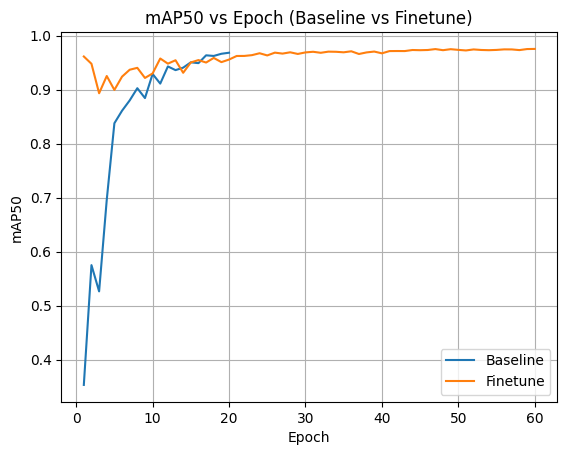

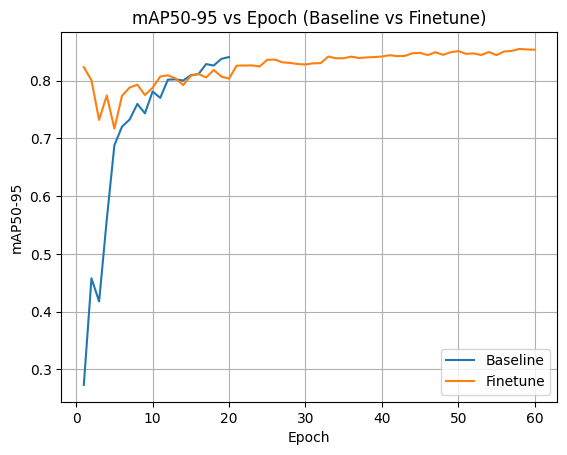

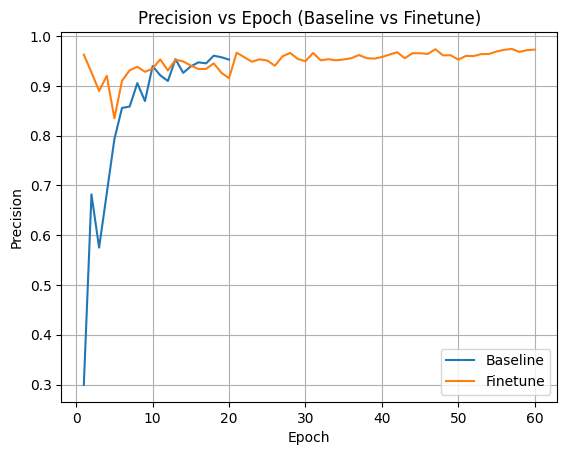

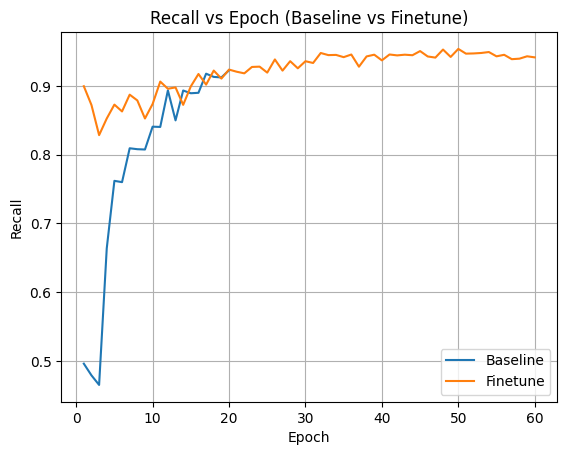

In [36]:
import matplotlib.pyplot as plt

# For convenience
be = baseline
fe = finetune

# 1) mAP50 curve
plt.figure()
plt.plot(be["epoch"], be["metrics/mAP50(B)"], label="Baseline")
plt.plot(fe["epoch"], fe["metrics/mAP50(B)"], label="Finetune")
plt.xlabel("Epoch")
plt.ylabel("mAP50")
plt.title("mAP50 vs Epoch (Baseline vs Finetune)")
plt.legend()
plt.grid(True)
plt.show()

# 2) mAP50-95 curve
plt.figure()
plt.plot(be["epoch"], be["metrics/mAP50-95(B)"], label="Baseline")
plt.plot(fe["epoch"], fe["metrics/mAP50-95(B)"], label="Finetune")
plt.xlabel("Epoch")
plt.ylabel("mAP50-95")
plt.title("mAP50-95 vs Epoch (Baseline vs Finetune)")
plt.legend()
plt.grid(True)
plt.show()

# 3) Precision curve
plt.figure()
plt.plot(be["epoch"], be["metrics/precision(B)"], label="Baseline")
plt.plot(fe["epoch"], fe["metrics/precision(B)"], label="Finetune")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision vs Epoch (Baseline vs Finetune)")
plt.legend()
plt.grid(True)
plt.show()

# 4) Recall curve
plt.figure()
plt.plot(be["epoch"], be["metrics/recall(B)"], label="Baseline")
plt.plot(fe["epoch"], fe["metrics/recall(B)"], label="Finetune")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall vs Epoch (Baseline vs Finetune)")
plt.legend()
plt.grid(True)
plt.show()


Baseline Training Curves:


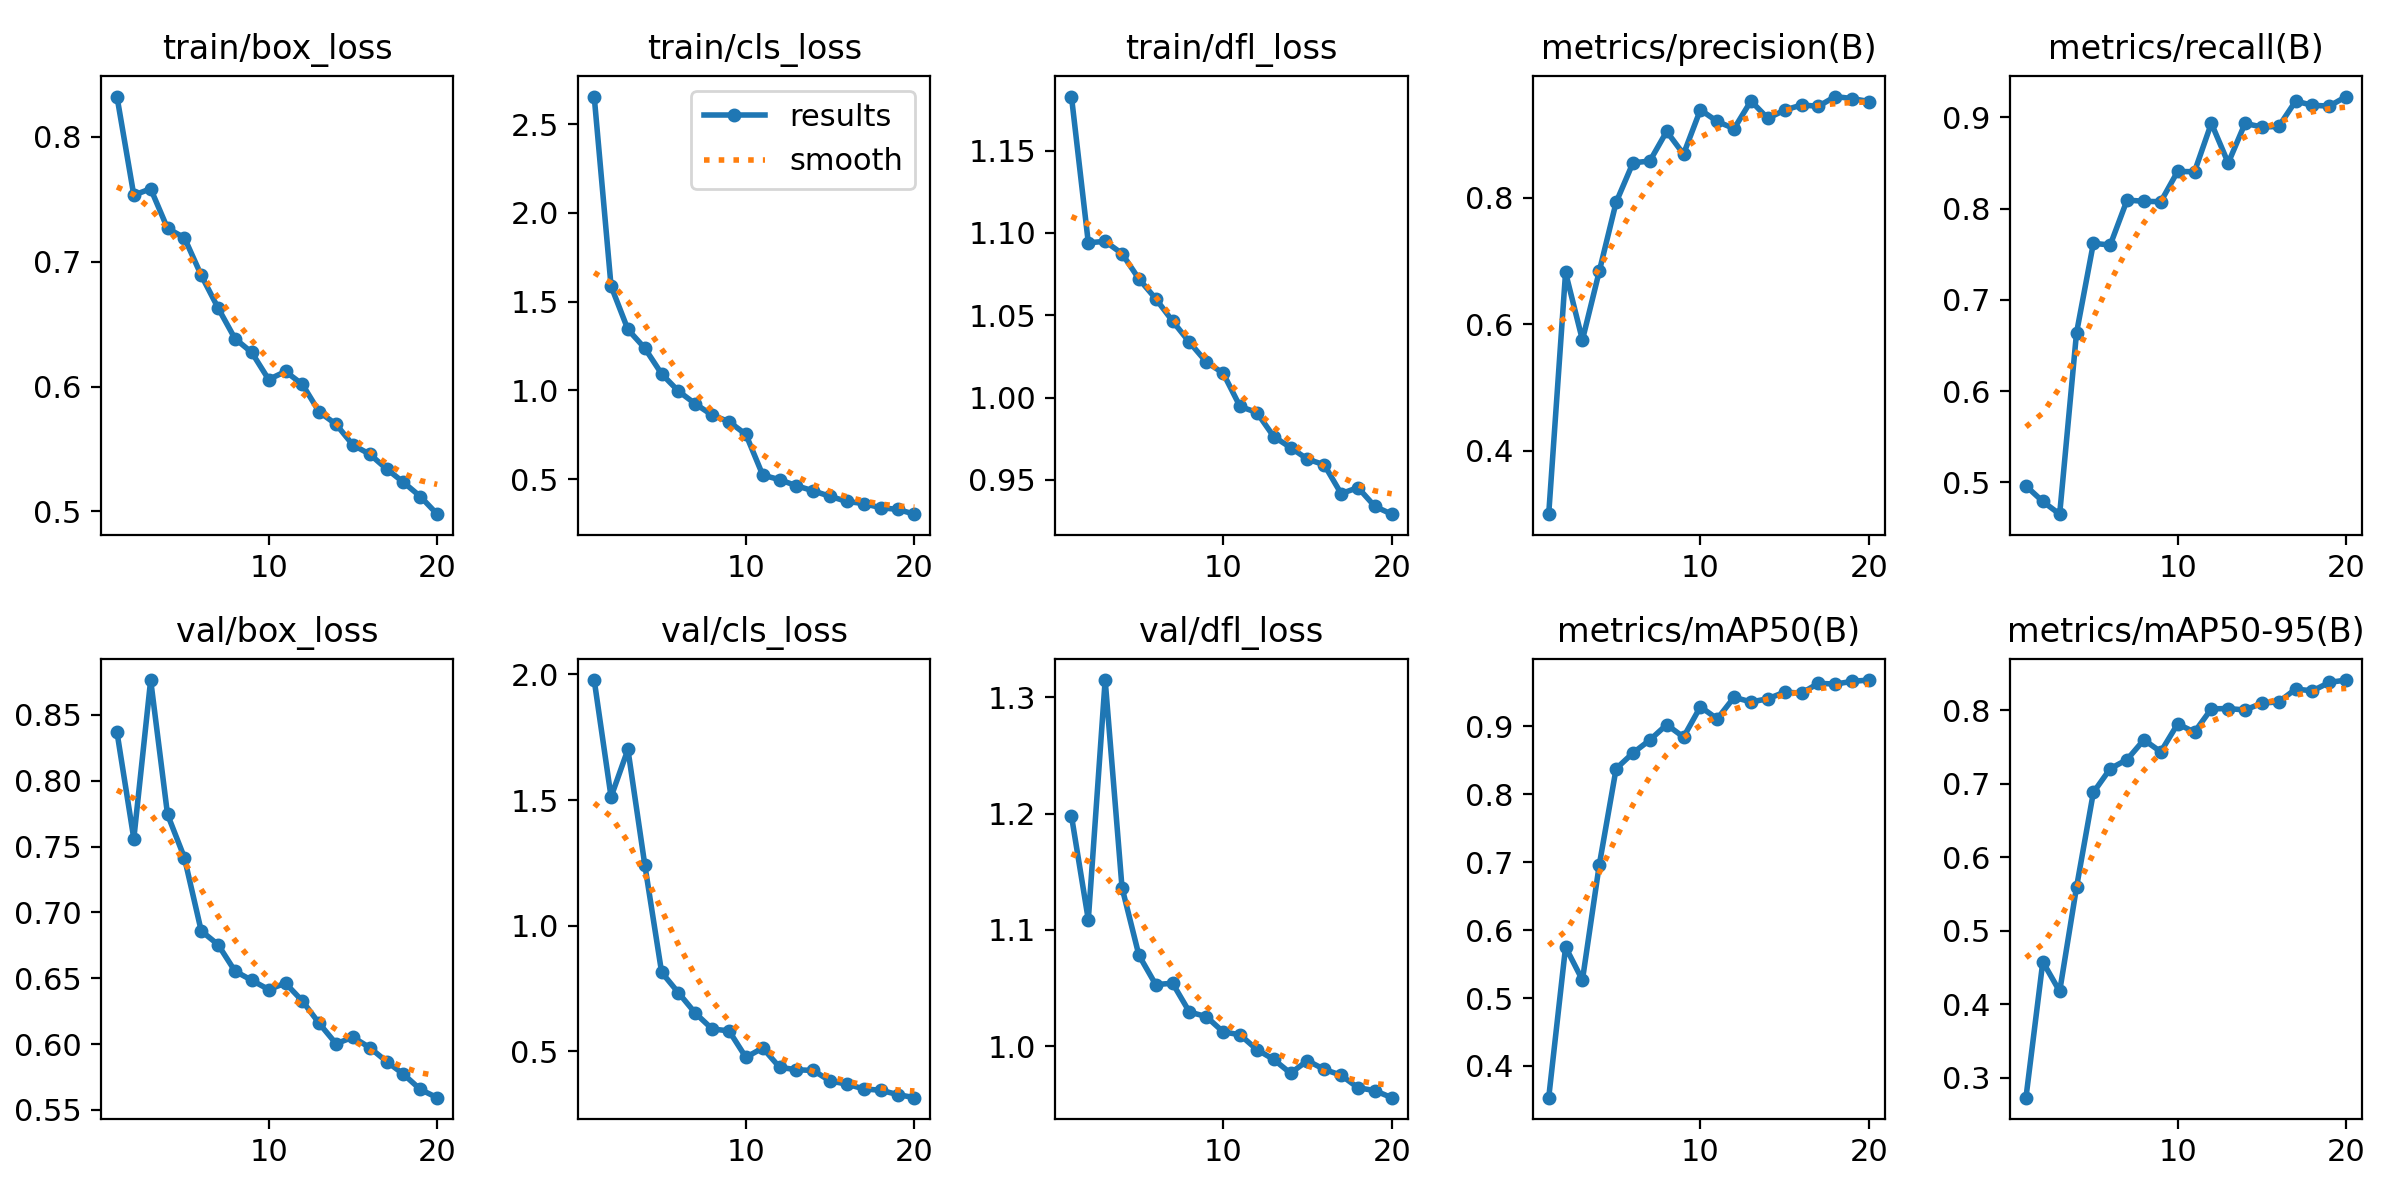

Finetune Training Curves:


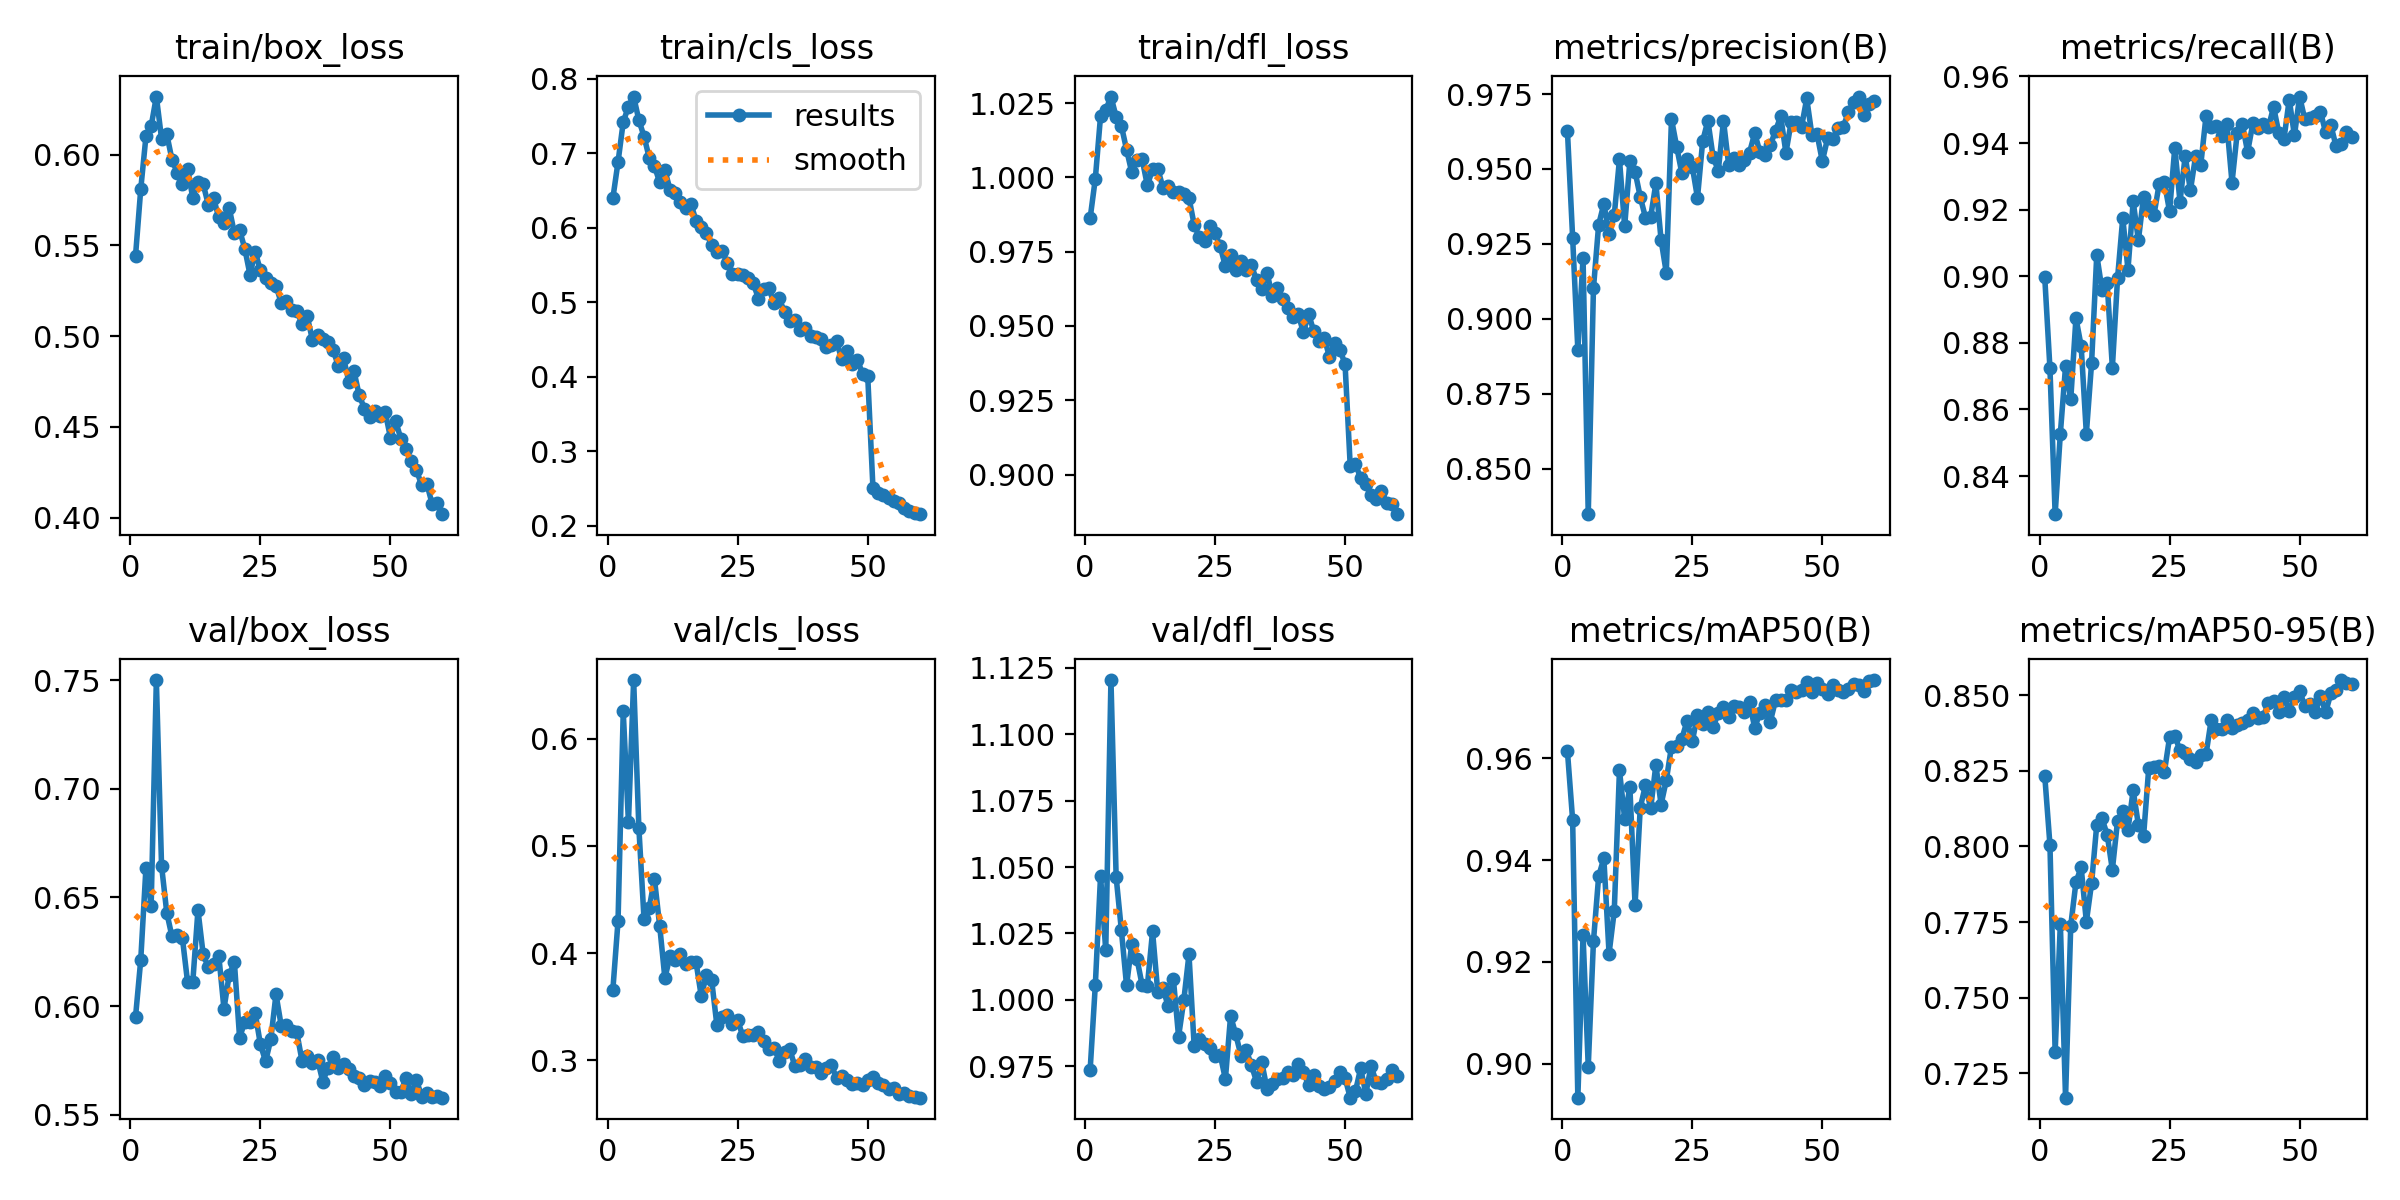

In [37]:
from IPython.display import Image, display

print("Baseline Training Curves:")
display(Image("/content/traffic_signs_exp/yolov8m_baseline/results.png"))

print("Finetune Training Curves:")
display(Image("/content/traffic_signs_exp/yolov8m_finetune/results.png"))


In [38]:
#1. Image size experiment (speed vs accuracy)
#Hypothesis: larger imgsz → better mAP but slower.

img_sizes = [512, 640, 800]

for imgsz in img_sizes:
    model = YOLO("yolov8m.pt")
    model.train(
        data=data_yaml,
        epochs=40,
        imgsz=imgsz,
        batch=32,
        lr0=0.005,
        patience=15,
        project="traffic_signs_exp",
        name=f"yolov8m_img{imgsz}",
        exist_ok=True,
    )

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cardetection/car/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_img512, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspec

In [39]:
# Paths to trained model weights
experiments = {
    "yolov8m_img512": "/content/traffic_signs_exp/yolov8m_img512/weights/best.pt",
    "yolov8m_img640": "/content/traffic_signs_exp/yolov8m_img640/weights/best.pt",
    "yolov8m_img800": "/content/traffic_signs_exp/yolov8m_img800/weights/best.pt",
}

rows = []

for name, path in experiments.items():
    model = YOLO(path)
    metrics = model.val(data=data_yaml, split="val")

    rows.append({
        "Model": name,
        "Precision": metrics.results_dict["metrics/precision(B)"],
        "Recall": metrics.results_dict["metrics/recall(B)"],
        "mAP50": metrics.results_dict["metrics/mAP50(B)"],
        "mAP50-95": metrics.results_dict["metrics/mAP50-95(B)"],
        "Inference Time (ms/img)": metrics.speed['inference'],  # ms per image
    })

df = pd.DataFrame(rows)
print(df)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,848,445 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 904.3±401.1 MB/s, size: 19.7 KB)
val: Scanning /content/cardetection/car/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 801/801 1.5Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 10.2it/s 5.0s
                   all        801        944      0.956      0.921      0.964      0.843
           Green Light         87        122       0.91      0.738      0.875      0.537
             Red Light         74        108       0.82      0.704      0.796      0.516
       Speed Limit 100         52         52          1      0.991      0.995      0.928
       Speed Limit 110         17         17      0.871      0.941      0.952      0.877
       Speed Limit 120    

In [40]:
base_dir = "/content/traffic_signs_exp"

runs = {
    512: f"{base_dir}/yolov8m_img512/results.csv",
    640: f"{base_dir}/yolov8m_img640/results.csv",
    800: f"{base_dir}/yolov8m_img800/results.csv",
}

metric_cols = [
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
    "metrics/precision(B)",
    "metrics/recall(B)",
]

rows = []

for imgsz, csv_path in runs.items():
    df = pd.read_csv(csv_path)

    # last epoch
    last = df.tail(1).iloc[0]

    # best epoch according to mAP50-95
    best_idx = df["metrics/mAP50-95(B)"].idxmax()
    best = df.loc[best_idx]

    rows.append({
        "imgsz": imgsz,
        "last_mAP50": last["metrics/mAP50(B)"],
        "last_mAP50-95": last["metrics/mAP50-95(B)"],
        "last_precision": last["metrics/precision(B)"],
        "last_recall": last["metrics/recall(B)"],
        "best_epoch": int(best["epoch"]),
        "best_mAP50-95": best["metrics/mAP50-95(B)"],
    })

comparison = pd.DataFrame(rows).sort_values("imgsz")
print("===== METRIC COMPARISON (Baseline vs Image Size) =====")
print(comparison.to_string(index=False))


===== METRIC COMPARISON (Baseline vs Image Size) =====
 imgsz  last_mAP50  last_mAP50-95  last_precision  last_recall  best_epoch  best_mAP50-95
   512     0.96381        0.84283         0.95593      0.92132          40        0.84283
   640     0.96815        0.84559         0.96546      0.93925          40        0.84559
   800     0.97433        0.85413         0.96757      0.95717          39        0.85597


In [42]:
import glob
import time

# CHANGE to your images (e.g. test set)
image_paths = sorted(glob.glob("/content/cardetection/car/test/images/*.jpg"))[:50]

weights = {
    512: f"{base_dir}/yolov8m_img512/weights/best.pt",
    640: f"{base_dir}/yolov8m_img640/weights/best.pt",
    800: f"{base_dir}/yolov8m_img800/weights/best.pt",
}

speed_rows = []

for imgsz, w in weights.items():
    model = YOLO(w)
    start = time.time()
    model.predict(image_paths, imgsz=imgsz, verbose=False)
    end = time.time()

    total_time = end - start
    avg_time = total_time / len(image_paths)
    fps = 1.0 / avg_time

    speed_rows.append({
        "imgsz": imgsz,
        "images": len(image_paths),
        "total_time_sec": total_time,
        "avg_time_sec_per_image": avg_time,
        "fps": fps,
    })

speed_df = pd.DataFrame(speed_rows).sort_values("imgsz")
print("===== INFERENCE SPEED COMPARISON =====")
print(speed_df.to_string(index=False))
#Speed vs accuracy tradeoff

===== INFERENCE SPEED COMPARISON =====
 imgsz  images  total_time_sec  avg_time_sec_per_image       fps
   512      50        0.518789                0.010376 96.378287
   640      50        0.588334                0.011767 84.985727
   800      50        0.700631                0.014013 71.364252


===== ACCURACY COMPARISON (BY IMAGE SIZE) =====
 imgsz  last_epoch  last_mAP50  last_mAP50-95  last_precision  last_recall  best_epoch  best_mAP50-95
   512          40     0.96381        0.84283         0.95593      0.92132          40        0.84283
   640          40     0.96815        0.84559         0.96546      0.93925          40        0.84559
   800          40     0.97433        0.85413         0.96757      0.95717          39        0.85597


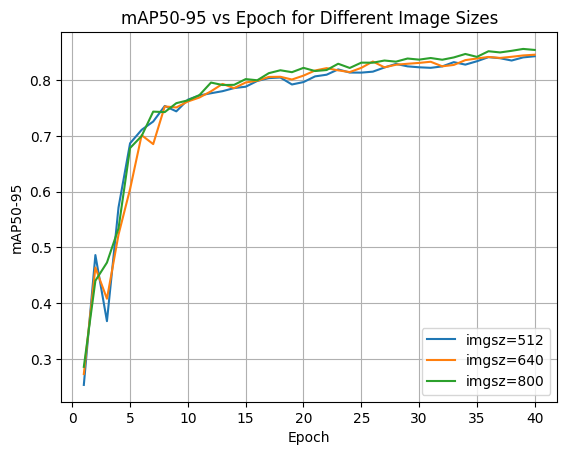

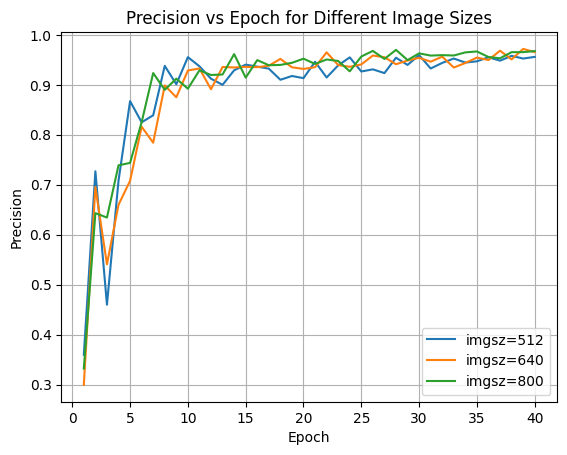

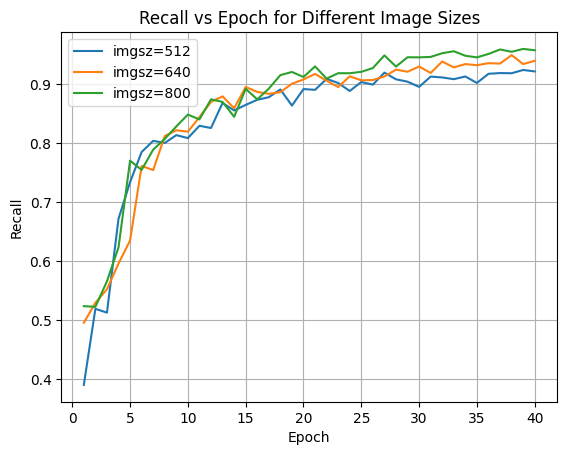

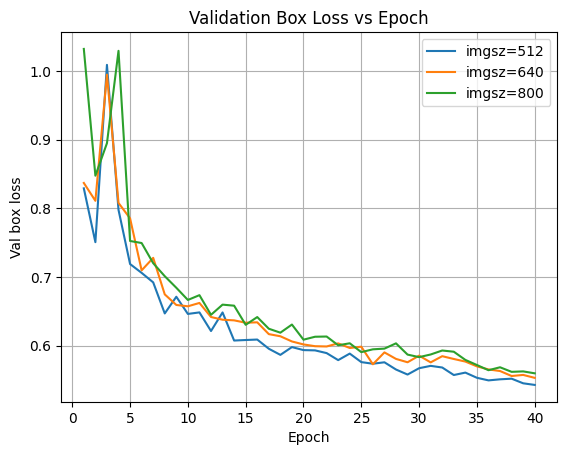

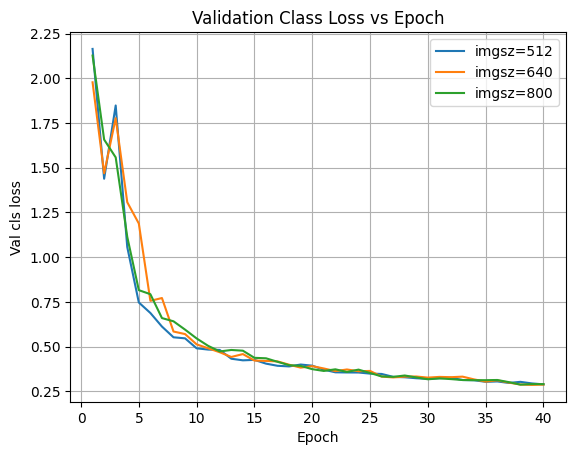

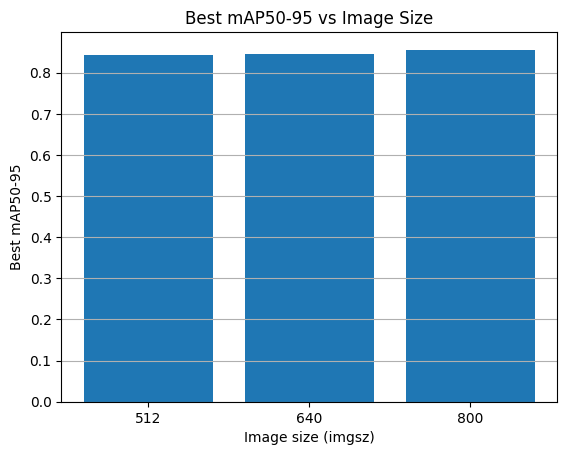


Running inference speed test for imgsz=512...

Running inference speed test for imgsz=640...

Running inference speed test for imgsz=800...

===== INFERENCE SPEED COMPARISON =====
 imgsz  images_tested  total_time_sec  avg_time_sec_per_image       fps
   512             50        0.519174                0.010383 96.306852
   640             50        0.598983                0.011980 83.474816
   800             50        0.724638                0.014493 68.999971


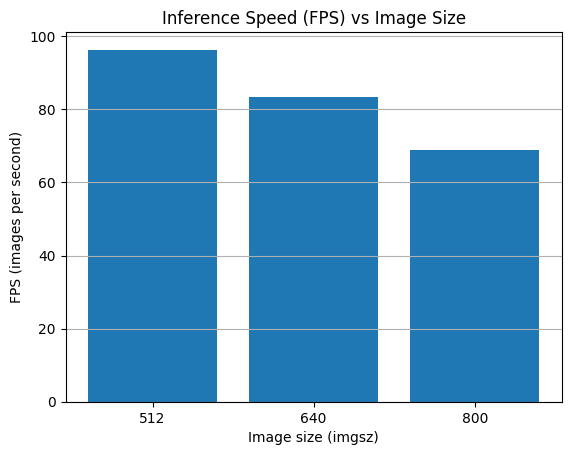

In [46]:
# Base directory
base_dir = "/content/traffic_signs_exp"  # <-- change if needed

# Names of the three runs (folders under base_dir)
runs = {
    512: "yolov8m_img512",
    640: "yolov8m_img640",
    800: "yolov8m_img800",
}

# Where your test images live (for speed test)
test_images_dir = "/content/cardetection/car/test/images"  # <-- change if needed
num_test_images = 50  # how many images to use for speed benchmark

# =========================
# LOAD RESULTS.CSV FOR EACH MODEL
# =========================

results = {}
for imgsz, run_name in runs.items():
    csv_path = os.path.join(base_dir, run_name, "results.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"results.csv not found for imgsz={imgsz} at {csv_path}")
    results[imgsz] = pd.read_csv(csv_path)

# =========================
# BUILD ACCURACY COMPARISON TABLE
# =========================

rows = []
for imgsz, df in results.items():
    # last epoch metrics
    last = df.tail(1).iloc[0]

    # best epoch according to mAP50-95
    best_idx = df["metrics/mAP50-95(B)"].idxmax()
    best = df.loc[best_idx]

    rows.append({
        "imgsz": imgsz,
        "last_epoch": int(last["epoch"]),
        "last_mAP50": last["metrics/mAP50(B)"],
        "last_mAP50-95": last["metrics/mAP50-95(B)"],
        "last_precision": last["metrics/precision(B)"],
        "last_recall": last["metrics/recall(B)"],
        "best_epoch": int(best["epoch"]),
        "best_mAP50-95": best["metrics/mAP50-95(B)"],
    })

comparison_df = pd.DataFrame(rows).sort_values("imgsz")
print("===== ACCURACY COMPARISON (BY IMAGE SIZE) =====")
print(comparison_df.to_string(index=False))

# =========================
# PLOTS: mAP, PRECISION, RECALL vs EPOCH
# =========================

# 1) mAP50-95 vs epoch
plt.figure()
for imgsz, df in results.items():
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label=f"imgsz={imgsz}")
plt.xlabel("Epoch")
plt.ylabel("mAP50-95")
plt.title("mAP50-95 vs Epoch for Different Image Sizes")
plt.grid(True)
plt.legend()
plt.show()

# 2) Precision vs epoch
plt.figure()
for imgsz, df in results.items():
    plt.plot(df["epoch"], df["metrics/precision(B)"], label=f"imgsz={imgsz}")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision vs Epoch for Different Image Sizes")
plt.grid(True)
plt.legend()
plt.show()

# 3) Recall vs epoch
plt.figure()
for imgsz, df in results.items():
    plt.plot(df["epoch"], df["metrics/recall(B)"], label=f"imgsz={imgsz}")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall vs Epoch for Different Image Sizes")
plt.grid(True)
plt.legend()
plt.show()

# =========================
# PLOTS: VALIDATION LOSSES vs EPOCH
# =========================

# 4) Val box loss vs epoch
plt.figure()
for imgsz, df in results.items():
    plt.plot(df["epoch"], df["val/box_loss"], label=f"imgsz={imgsz}")
plt.xlabel("Epoch")
plt.ylabel("Val box loss")
plt.title("Validation Box Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.show()

# 5) Val cls loss vs epoch
plt.figure()
for imgsz, df in results.items():
    plt.plot(df["epoch"], df["val/cls_loss"], label=f"imgsz={imgsz}")
plt.xlabel("Epoch")
plt.ylabel("Val cls loss")
plt.title("Validation Class Loss vs Epoch")
plt.grid(True)
plt.legend()
plt.show()

# =========================
# BAR PLOTS: ACCURACY vs IMAGE SIZE
# =========================

imgsz_list = sorted(results.keys())
best_map_list = [
    comparison_df[comparison_df["imgsz"] == s]["best_mAP50-95"].values[0]
    for s in imgsz_list
]

plt.figure()
plt.bar([str(s) for s in imgsz_list], best_map_list)
plt.xlabel("Image size (imgsz)")
plt.ylabel("Best mAP50-95")
plt.title("Best mAP50-95 vs Image Size")
plt.grid(axis="y")
plt.show()

# =========================
# INFERENCE SPEED vs IMAGE SIZE
# =========================

# Collect some test images
image_paths = sorted(
    glob.glob(os.path.join(test_images_dir, "*.jpg"))
    + glob.glob(os.path.join(test_images_dir, "*.png"))
)[:num_test_images]

if len(image_paths) == 0:
    print("\nNo test images found for speed test. Check test_images_dir path.")
else:
    speed_rows = []
    for imgsz, run_name in runs.items():
        weights_path = os.path.join(base_dir, run_name, "weights", "best.pt")
        if not os.path.exists(weights_path):
            print(f"Skipping imgsz={imgsz}, weights not found at {weights_path}")
            continue

        print(f"\nRunning inference speed test for imgsz={imgsz}...")
        model = YOLO(weights_path)

        start = time.time()
        model.predict(image_paths, imgsz=imgsz, verbose=False)
        end = time.time()

        total_time = end - start
        avg_time = total_time / len(image_paths)
        fps = 1.0 / avg_time

        speed_rows.append({
            "imgsz": imgsz,
            "images_tested": len(image_paths),
            "total_time_sec": total_time,
            "avg_time_sec_per_image": avg_time,
            "fps": fps,
        })

    if speed_rows:
        speed_df = pd.DataFrame(speed_rows).sort_values("imgsz")
        print("\n===== INFERENCE SPEED COMPARISON =====")
        print(speed_df.to_string(index=False))

        # BAR PLOT: FPS vs image size
        plt.figure()
        plt.bar(speed_df["imgsz"].astype(str), speed_df["fps"])
        plt.xlabel("Image size (imgsz)")
        plt.ylabel("FPS (images per second)")
        plt.title("Inference Speed (FPS) vs Image Size")
        plt.grid(axis="y")
        plt.show()
    else:
        print("\nNo speed data collected (missing weights or images).")


In [47]:
# ================= COPY MODEL: imgsz = 512 =================
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_img512"
!cp -r "/content/traffic_signs_exp/yolov8m_img512/"* \
       "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_img512/"

# ================= COPY MODEL: imgsz = 640 =================
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_img640"
!cp -r "/content/traffic_signs_exp/yolov8m_img640/"* \
       "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_img640/"

# ================= COPY MODEL: imgsz = 800 =================
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_img800"
!cp -r "/content/traffic_signs_exp/yolov8m_img800/"* \
       "/content/drive/MyDrive/CMPE-257_Yolov8/yolov8m_img800/"

In [48]:
lr_configs = [
    {"name": "yolov8m_lr0.003", "lr0": 0.003},
    {"name": "yolov8m_lr0.005", "lr0": 0.005},  # your current
    {"name": "yolov8m_lr0.01",  "lr0": 0.01},
]

for cfg in lr_configs:
    model = YOLO("yolov8m.pt")
    model.train(
        data=data_yaml,
        epochs=40,
        imgsz=640,
        batch=32,
        lr0=cfg["lr0"],
        lrf=0.01,          # final LR = lr0 * lrf (strong decay)
        patience=15,
        project="traffic_signs_exp",
        name=cfg["name"],
        exist_ok=True,
    )


Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/cardetection/car/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8m_lr0.003, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspe

In [52]:
# Create base directory in Drive
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/lr_experiments"

# ================= COPY MODEL: lr0 = 0.003 =================
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/lr_experiments/yolov8m_lr0.003"
!cp -r "/content/traffic_signs_exp/yolov8m_lr0.003/"* \
       "/content/drive/MyDrive/CMPE-257_Yolov8/lr_experiments/yolov8m_lr0.003/"

# ================= COPY MODEL: lr0 = 0.005 =================
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/lr_experiments/yolov8m_lr0.005"
!cp -r "/content/traffic_signs_exp/yolov8m_lr0.005/"* \
       "/content/drive/MyDrive/CMPE-257_Yolov8/lr_experiments/yolov8m_lr0.005/"

# ================= COPY MODEL: lr0 = 0.01 =================
!mkdir -p "/content/drive/MyDrive/CMPE-257_Yolov8/lr_experiments/yolov8m_lr0.01"
!cp -r "/content/traffic_signs_exp/yolov8m_lr0.01/"* \
       "/content/drive/MyDrive/CMPE-257_Yolov8/lr_experiments/yolov8m_lr0.01/"


===== LEARNING RATE SWEEP COMPARISON =====
  lr0  last_precision  last_recall  last_mAP50  last_mAP50-95  best_epoch  best_mAP50-95
0.003         0.96546      0.93925     0.96815        0.84559          40        0.84559
0.005         0.96546      0.93925     0.96815        0.84559          40        0.84559
0.010         0.96546      0.93925     0.96815        0.84559          40        0.84559


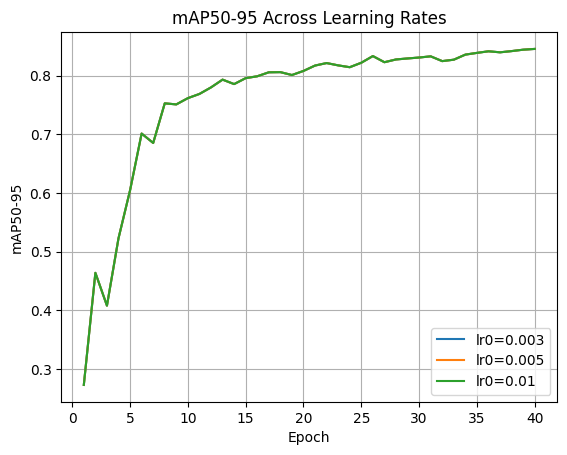

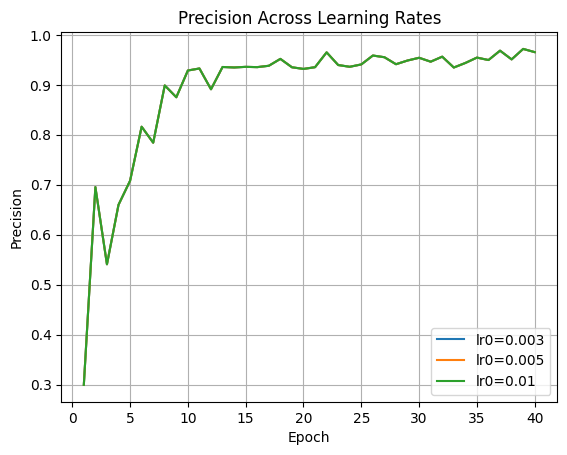

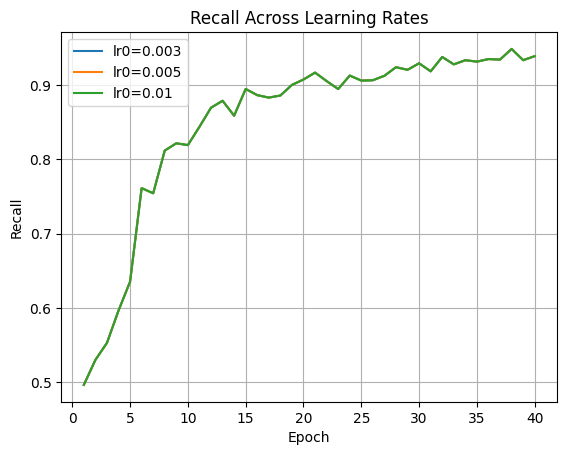

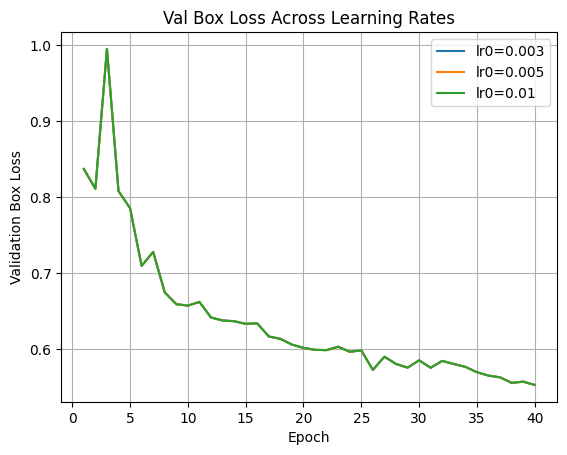

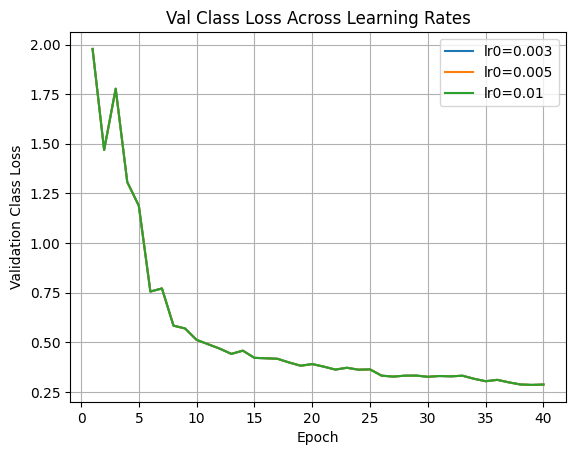

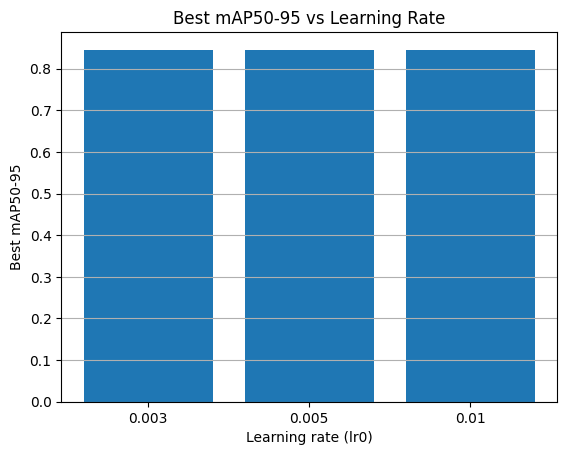

In [53]:
base_dir = "/content/traffic_signs_exp"  # folder where YOLO runs are saved

lr_runs = {
    0.003: f"{base_dir}/yolov8m_lr0.003/results.csv",
    0.005: f"{base_dir}/yolov8m_lr0.005/results.csv",
    0.01:  f"{base_dir}/yolov8m_lr0.01/results.csv",
}

# =========================
# LOAD RESULTS
# =========================

results = {}
for lr, csv_path in lr_runs.items():
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Missing CSV for lr={lr}: {csv_path}")
    results[lr] = pd.read_csv(csv_path)

# =========================
# BUILD ACCURACY COMPARISON TABLE
# =========================

rows = []
for lr, df in results.items():
    last = df.tail(1).iloc[0]

    # best mAP epoch
    best_idx = df["metrics/mAP50-95(B)"].idxmax()
    best = df.loc[best_idx]

    rows.append({
        "lr0": lr,
        "last_precision": last["metrics/precision(B)"],
        "last_recall": last["metrics/recall(B)"],
        "last_mAP50": last["metrics/mAP50(B)"],
        "last_mAP50-95": last["metrics/mAP50-95(B)"],
        "best_epoch": int(best["epoch"]),
        "best_mAP50-95": best["metrics/mAP50-95(B)"],
    })

comparison_df = pd.DataFrame(rows).sort_values("lr0")
print("===== LEARNING RATE SWEEP COMPARISON =====")
print(comparison_df.to_string(index=False))

# =========================
# PLOTS: METRICS vs EPOCH
# =========================

# 1) mAP50-95 vs epoch
plt.figure()
for lr, df in results.items():
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label=f"lr0={lr}")
plt.xlabel("Epoch")
plt.ylabel("mAP50-95")
plt.title("mAP50-95 Across Learning Rates")
plt.grid(True)
plt.legend()
plt.show()

# 2) Precision vs epoch
plt.figure()
for lr, df in results.items():
    plt.plot(df["epoch"], df["metrics/precision(B)"], label=f"lr0={lr}")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision Across Learning Rates")
plt.grid(True)
plt.legend()
plt.show()

# 3) Recall vs epoch
plt.figure()
for lr, df in results.items():
    plt.plot(df["epoch"], df["metrics/recall(B)"], label=f"lr0={lr}")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall Across Learning Rates")
plt.grid(True)
plt.legend()
plt.show()

# =========================
# PLOTS: VALIDATION LOSSES vs EPOCH
# =========================

# 4) Box loss
plt.figure()
for lr, df in results.items():
    plt.plot(df["epoch"], df["val/box_loss"], label=f"lr0={lr}")
plt.xlabel("Epoch")
plt.ylabel("Validation Box Loss")
plt.title("Val Box Loss Across Learning Rates")
plt.grid(True)
plt.legend()
plt.show()

# 5) Classification loss
plt.figure()
for lr, df in results.items():
    plt.plot(df["epoch"], df["val/cls_loss"], label=f"lr0={lr}")
plt.xlabel("Epoch")
plt.ylabel("Validation Class Loss")
plt.title("Val Class Loss Across Learning Rates")
plt.grid(True)
plt.legend()
plt.show()

# =========================
# BAR PLOT: BEST mAP50-95 vs LR
# =========================

plt.figure()
plt.bar(
    [str(lr) for lr in comparison_df["lr0"]],
    comparison_df["best_mAP50-95"]
)
plt.xlabel("Learning rate (lr0)")
plt.ylabel("Best mAP50-95")
plt.title("Best mAP50-95 vs Learning Rate")
plt.grid(axis="y")
plt.show()
